# Handwritten Digit Recognition (MNIST)
## Using 5 layer Convolutional Neural Network 
### Activation function: RELU  
### Learning rate: dynamic 
### Including Dropouts for each RELU layer
### Batch Normalization

In [1]:
# including helper file to use some handy functions
import os
helper_file = os.getcwd() + '\\helpers.ipynb'
%run $helper_file

# importing needed libraries
import numpy as np
import tensorflow as tf
import math
import pandas as pd

In [2]:
# reading train and test file
train_data = pd.read_csv(os.getcwd() + '\\Kaggle\\train.csv')
pred_data   = pd.read_csv(os.getcwd() + '\\Kaggle\\test.csv')

In [14]:
# parameters
BATCH_SIZE = 100
ITERATION_COUNT = 1000
ACCURACY_CHECK = 100
TOTAL_COUNT = len(train_data) # training image count in input csv file
TEST_COUNT = 3000
TRAIN_COUNT = TOTAL_COUNT - TEST_COUNT
IMAGE_WIDTH  = 28 # input image width
IMAGE_HEIGHT = 28 # input image height

In [4]:
# extracting pixel values for each image
# input pixel values range is [0:255]
# we need to change the range to [0:1]
# the easiest way is to devide by maximum 255
X_all_flat = train_data.iloc[:, 1:].values / 255
X_pred_flat = pred_data.values / 255

# extracting labels
Y_all = train_data.iloc[:, :1].values

# creating list for each label
# each row's values will be zero 
# except the index of the label
# mapping should be as below: 
# 0 ~ [1 0 0 0 0 0 0 0 0 0]
# 1 ~ [0 1 0 0 0 0 0 0 0 0]
# 2 ~ [0 0 1 0 0 0 0 0 0 0]
# 3 ~ [0 0 0 1 0 0 0 0 0 0]
# 4 ~ [0 0 0 0 1 0 0 0 0 0]
# 5 ~ [0 0 0 0 0 1 0 0 0 0]
# 6 ~ [0 0 0 0 0 0 1 0 0 0]
# 7 ~ [0 0 0 0 0 0 0 1 0 0]
# 8 ~ [0 0 0 0 0 0 0 0 1 0]
# 9 ~ [0 0 0 0 0 0 0 0 0 1]
Y_labels = np.zeros(shape=(TOTAL_COUNT,10))
for i in range(TOTAL_COUNT):
    Y_labels[i][Y_all[i]] = 1

# splitting images to train and test data to validate our prediction
X_train_flat  = X_all_flat[:TRAIN_COUNT]
X_test_flat   = X_all_flat[TRAIN_COUNT:]

# splitting labels to train and test data to validate our prediction
Y_train = Y_labels[:TRAIN_COUNT]
Y_test  = Y_labels[TRAIN_COUNT:TOTAL_COUNT]

In [5]:
# the batch size equals to BATCH_SIZE it will
# starts from 0 to until the last index of
# batch equals to TOTAL_COUNT
BATCH_COUNTER = 0

def next_batch(all_images, all_labels):
    
    # accessing BATCH_COUNTER inside function
    global BATCH_COUNTER
    
    # check if exceeds to the last index then reset batch_counter
    if BATCH_COUNTER == len(all_labels) / BATCH_SIZE:
        BATCH_COUNTER = 0

    # setting first and last index of data
    index_from = BATCH_COUNTER * BATCH_SIZE
    index_to   = (BATCH_COUNTER + 1) * BATCH_SIZE
    
    # loading a batch of training images and labels
    image_batch = all_images[index_from:index_to]
    label_batch = all_labels[index_from:index_to]
    
    # incrementing batch_counter for the next iteration
    BATCH_COUNTER += 1 
    
    return image_batch, label_batch;

In [6]:
# reshape 1 dimentional array of pixel data 
# to 2 dimentional 28x28 pixles
def reshape_image(flatten_image_data):
    return np.reshape(flatten_image_data, (-1, IMAGE_WIDTH, IMAGE_HEIGHT, 1))

In [7]:
def train_model(train_X_flat, train_Y, test_X_flat, test_Y):

    C0 = 1   # input channel count
    C1 = 24  # convolutional network channel 1 count 
    C2 = 48  # convolutional network channel 2 count
    C3 = 64  # convolutional network channel 3 count
    C4 = 200 # fulley connected layer size
    C5 = 10  # output count (digit count 0 to 9)
    
    # input image placeholder: 28x28 grayscale
    # the first dimension is each image's index
    X = tf.placeholder(tf.float32, shape=[None, IMAGE_WIDTH, IMAGE_HEIGHT, C0])
    
    # placeholder for correct answers
    Y_ = tf.placeholder(tf.float32, [None, C5])
    
    # paceholder for learing_rate variable
    lr = tf.placeholder(tf.float32)
    
    # test flag for batch norm
    tst = tf.placeholder(tf.bool)
    iter = tf.placeholder(tf.int32)
    
    # dropout probability
    pkeep = tf.placeholder(tf.float32)
    pkeep_conv = tf.placeholder(tf.float32)
    
    def batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
        exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, iteration) # adding the iteration prevents from averaging across non-existing iterations
        bnepsilon = 1e-5
        if convolutional:
            mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
        else:
            mean, variance = tf.nn.moments(Ylogits, [0])
        update_moving_everages = exp_moving_avg.apply([mean, variance])
        m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
        v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
        Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
        return Ybn, update_moving_everages

    def no_batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
        return Ylogits, tf.no_op()
    
    def compatible_convolutional_noise_shape(Y):
        noiseshape = tf.shape(Y)
        noiseshape = noiseshape * tf.constant([1,0,0,1]) + tf.constant([0,1,1,0])
        return noiseshape
        
    # weights
    W1 = tf.Variable(tf.truncated_normal([6, 6, C0, C1], stddev = 0.1)) 
    W2 = tf.Variable(tf.truncated_normal([5, 5, C1, C2], stddev = 0.1))
    W3 = tf.Variable(tf.truncated_normal([4, 4, C2, C3], stddev = 0.1))
    W4 = tf.Variable(tf.truncated_normal([7 * 7 * C3, C4], stddev = 0.1))
    W5 = tf.Variable(tf.truncated_normal([C4, C5], stddev = 0.1))
    
    # biases
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [C1]))
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [C2]))
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [C3]))
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [C4]))
    B5 = tf.Variable(tf.constant(0.1, tf.float32, [C5]))

    # Probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
    pkeep = tf.placeholder(tf.float32)
    
    # model
    stride = 1  # output is 28x28
    Y1l = tf.nn.conv2d(X, W1, strides = [1, stride, stride, 1], padding = 'SAME')
    Y1bn, update_ema1 = batchnorm(Y1l, tst, iter, B1, convolutional = True)
    Y1r = tf.nn.relu(Y1bn)
    Y1 = tf.nn.dropout(Y1r, pkeep_conv, compatible_convolutional_noise_shape(Y1r))

    stride = 2  # output is 14x14
    Y2l = tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME')
    Y2bn, update_ema2 = batchnorm(Y2l, tst, iter, B2, convolutional=True)
    Y2r = tf.nn.relu(Y2bn)
    Y2 = tf.nn.dropout(Y2r, pkeep_conv, compatible_convolutional_noise_shape(Y2r))

    stride = 2  # output is 7x7
    Y3l = tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME')
    Y3bn, update_ema3 = batchnorm(Y3l, tst, iter, B3, convolutional=True)
    Y3r = tf.nn.relu(Y3bn)
    Y3 = tf.nn.dropout(Y3r, pkeep_conv, compatible_convolutional_noise_shape(Y3r))

    # reshape the output from the third convolution for the fully connected layer
    YY = tf.reshape(Y3, shape=[-1, 7 * 7 * C3])
    
    Y4l = tf.matmul(YY, W4)
    Y4bn, update_ema4 = batchnorm(Y4l, tst, iter, B4)
    Y4r = tf.nn.relu(Y4bn)
    Y4 = tf.nn.dropout(Y4r, pkeep)
    Ylogits = tf.matmul(Y4, W5) + B5
    Y = tf.nn.softmax(Ylogits)
    
    update_ema = tf.group(update_ema1, update_ema2, update_ema3, update_ema4)

    # cross-entropy loss function (= -sum(Y_i * log(Yi)) ), normalised for batches of 100  images
    # TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
    # problems with log(0) which is NaN
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = Ylogits, labels = Y_)
    cross_entropy = tf.reduce_mean(cross_entropy) * 100
    
    # accuracy of the trained model, between 0 (worst) and 1 (best)
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # training step, the learning rate is a placeholder
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

    # initialisation
    init = tf.global_variables_initializer()

    # start computation
    sess = tf.Session()
    sess.run(init)
    
    # preparing return values
    counter = 0 
    upper_bound = int(ITERATION_COUNT / ACCURACY_CHECK)
    train_accuracy = np.zeros(upper_bound)
    train_loss = np.zeros(upper_bound)
    test_accuracy = np.zeros(upper_bound)
    test_loss = np.zeros(upper_bound)
    learning_rates = np.zeros(1)
    
    test_X = reshape_image(test_X_flat)
    
    for i in range(ITERATION_COUNT):
        
        # learning rate decay
        max_learning_rate = 0.002
        min_learning_rate = 0.0001
        decay_speed = 1600
        learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)
        
        # load batch of images and correct answers
        batch_X_flat, batch_Y = next_batch(train_X_flat, train_Y)
        batch_X = reshape_image(batch_X_flat)
        
        # train
        # the backpropagation training step
        sess.run(train_step, {X: batch_X, Y_: batch_Y, lr: learning_rate, tst: False, pkeep: 0.50, pkeep_conv: 1.0})
        sess.run(update_ema, {X: batch_X, Y_: batch_Y, tst: False, iter: i, pkeep: 1.0, pkeep_conv: 1.0})
        
        if (i + 1) % ACCURACY_CHECK == 0:

            a, c = sess.run([accuracy, cross_entropy], {X: batch_X, Y_: batch_Y, tst: False, pkeep: 1.0, pkeep_conv: 1.0})
            train_accuracy[counter] = a
            train_loss[counter] = c
            
            print(str(i + 1) + ': TA:' + str(a) + ' TL: ' + str(c) + ' (LR:' + str(learning_rate) + ')', end = ' ')
        
        
            pred, a, c = sess.run([Y, accuracy, cross_entropy], {X: test_X, Y_: test_Y, tst: True, pkeep: 1.0, pkeep_conv: 1.0})
            test_accuracy[counter] = a
            test_loss[counter] = c
            print('TSA:' + str(a) + ' TSL: ' + str(c))

            counter += 1
    
    learning_rates[0] = learning_rate
    predictions = tf.argmax(pred,1).eval(session=sess)
    sess.close()

    return learning_rates, train_accuracy, train_loss, test_accuracy, test_loss, predictions
    

In [15]:
train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []
learning_rates = []

%time lr, ta, tl, tsa, tsl, preds = train_model(X_train_flat, Y_train, X_test_flat, Y_test)

learning_rates.append(lr)
train_accuracy.append(ta)
train_loss.append(tl)
test_accuracy.append(tsa)
test_loss.append(tsl)
acc_check = np.arange(0, len(train_accuracy[0]))

100: TA:0.95 TL: 16.4902 (LR:0.0018860007210406498) TSA:0.963 TSL: 13.6981
200: TA:0.98 TL: 7.33848 (LR:0.0017777924075398732) TSA:0.966 TSL: 9.58933
300: TA:0.98 TL: 5.645 (LR:0.0016761401043322275) TSA:0.978 TSL: 7.66668
400: TA:0.99 TL: 2.16819 (LR:0.0015806466028338891) TSA:0.978 TSL: 6.4941
500: TA:1.0 TL: 1.29211 (LR:0.001490938760112552) TSA:0.983 TSL: 4.69611
600: TA:0.97 TL: 9.60715 (LR:0.0014066660408233107) TSA:0.983 TSL: 4.49602
700: TA:1.0 TL: 2.36781 (LR:0.0013274991474841846) TSA:0.985 TSL: 4.82146
800: TA:0.98 TL: 6.12588 (LR:0.001253128733739048) TSA:0.984 TSL: 4.60095
900: TA:0.99 TL: 5.1027 (LR:0.0011832641955800242) TSA:0.984 TSL: 4.82769
1000: TA:1.0 TL: 0.39181 (LR:0.0011176325358060067) TSA:0.99 TSL: 4.0695
Wall time: 1min 29s


In [9]:
def plot_performance_chart(X, Ys, legend_labels, label, loc = 'lower right', xmin = None, xmax = None, ymin = None, ymax = None):
    
    COLORS = ['r', 'g', 'b', 'm', 'c', 'y']
    
    if not(Ys is None):
        
        plt.figure(figsize=(10,4))
        
        for i in range(len(legend_labels)):
            plt.plot(X, Ys[i], c = COLORS[i], label = legend_labels[i])
            plt.legend(loc = loc, frameon = True, prop = {'size':7}, title = "Learning Rate")
            
            if not(xmin is None):
                plt.xlim(xmin = xmin, xmax = xmax)
                
            if not(ymin is None):
                plt.ylim(ymin = ymin, ymax = ymax)

        plt.ylabel(label)
        plt.xlabel('Steps')
        plt.show()

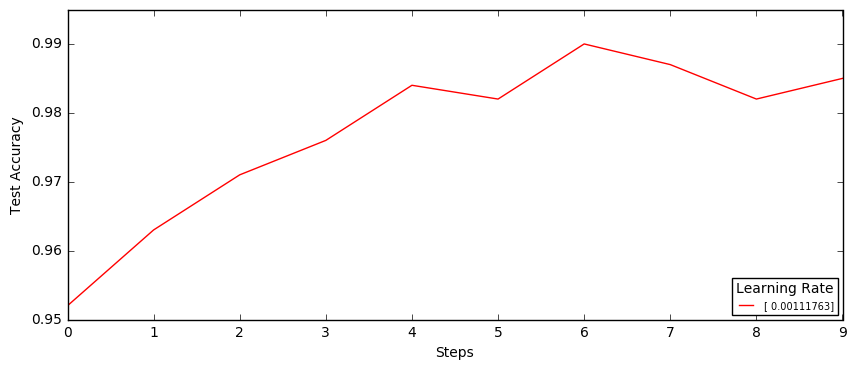

In [10]:
plot_performance_chart(acc_check, test_accuracy, learning_rates, 'Test Accuracy')

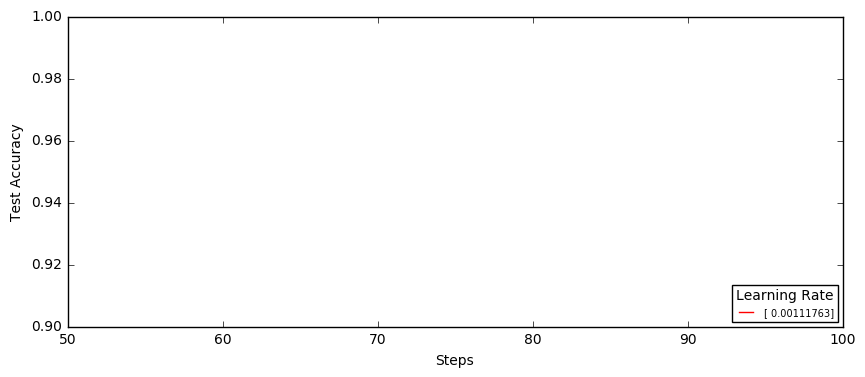

In [11]:
plot_performance_chart(acc_check, test_accuracy, learning_rates, 'Test Accuracy', 
                       xmin = 50, xmax = 100, ymin = 0.90, ymax = 1)

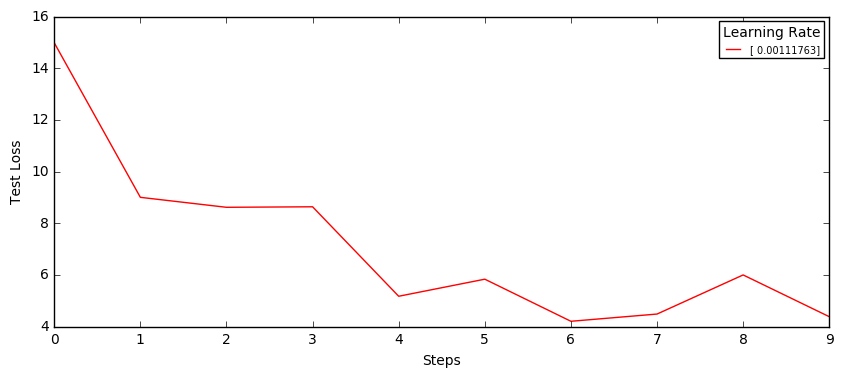

In [12]:
plot_performance_chart(acc_check, test_loss, learning_rates, 'Test Loss', loc = 'upper right')

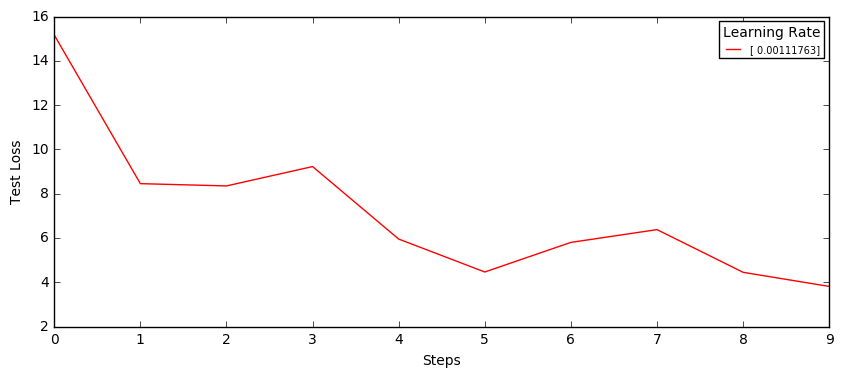

In [15]:
plot_performance_chart(acc_check, test_loss, learning_rates, 'Test Loss', loc = 'upper right')

IndexError: index 10 is out of bounds for axis 0 with size 10

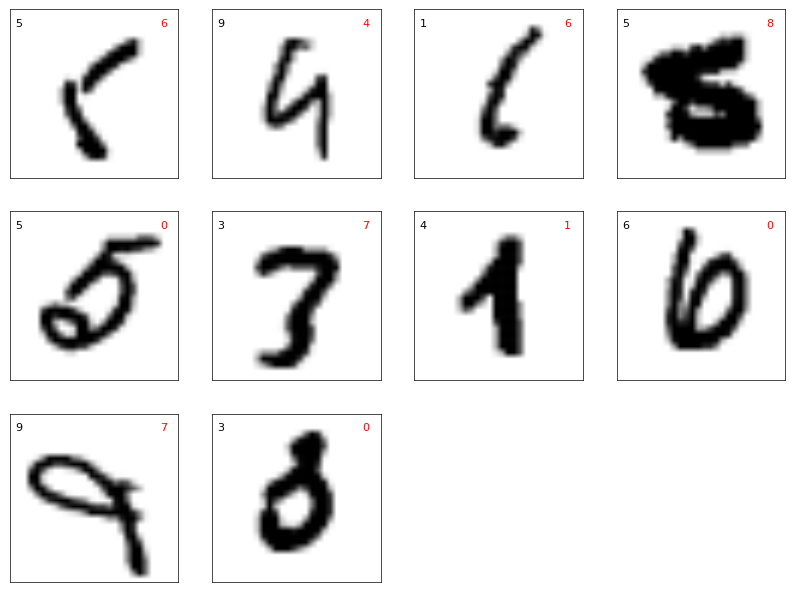

In [16]:
labels = np.argmax(Y_test, 1)
incorrects = np.not_equal(labels, preds)
plot_batch_images(X_test_flat[incorrects], labels[incorrects], preds[incorrects], 16)